In [ ]:
import numpy as np
import pandas as pd
import os
import bq_helper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.externals import joblib
pd.options.mode.chained_assignment = None  # default='warn'
import os
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from zipfile import ZipFile
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
%%bash
pip install MulticoreTSNE

In [ ]:
# https://github.com/DmitryUlyanov/Multicore-TSNE
# pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
%%bash
pip install hdbscan

In [ ]:
import hdbscan

In [ ]:
# create a helper object for this dataset
nyc_open_data = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="new_york")

In [ ]:
nyc_open_data.list_tables()

In [ ]:
query_trips = """
SELECT
    pickup_datetime,
    dropoff_datetime,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude
FROM
    `bigquery-public-data.new_york.tlc_yellow_trips_2016`
WHERE
    (EXTRACT(MONTH FROM pickup_datetime) = 5) AND
    (dropoff_longitude BETWEEN -74.03 AND 73.94) AND
    (dropoff_latitude BETWEEN 40.7 AND 40.8) AND
    (pickup_longitude BETWEEN -74.03 AND 73.94) AND
    (pickup_latitude BETWEEN 40.7 AND 40.8) AND
    pickup_datetime IS NOT NULL AND 
    dropoff_datetime IS NOT NULL
LIMIT 500000;
"""

In [ ]:
df_trips = nyc_open_data.query_to_pandas_safe(query_trips, max_gb_scanned=5.)

In [29]:
len(df_trips)

500000

In [30]:
df_trips.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-05-22 15:01:37+00:00,2016-05-22 15:26:51+00:00,-74.003403,40.752537,-73.987976,40.780369
1,2016-05-24 15:05:37+00:00,2016-05-24 15:37:45+00:00,-73.988495,40.736946,-73.872536,40.774471
2,2016-05-14 15:09:29+00:00,2016-05-14 15:44:58+00:00,-74.014183,40.704620,-73.975113,40.765331
3,2016-05-21 21:31:32+00:00,2016-05-21 22:13:55+00:00,-73.993904,40.751602,-73.981995,40.716702
4,2016-05-10 16:29:09+00:00,2016-05-10 17:09:57+00:00,-73.995628,40.749100,-73.946762,40.708668


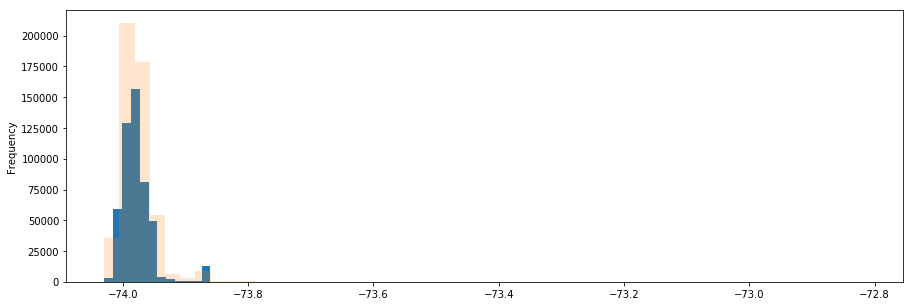

In [31]:
df_trips.pickup_longitude.plot(kind='hist', bins=50, figsize=(15, 5))
df_trips.dropoff_longitude.plot(kind='hist', bins=50, figsize=(15, 5), alpha=0.2)

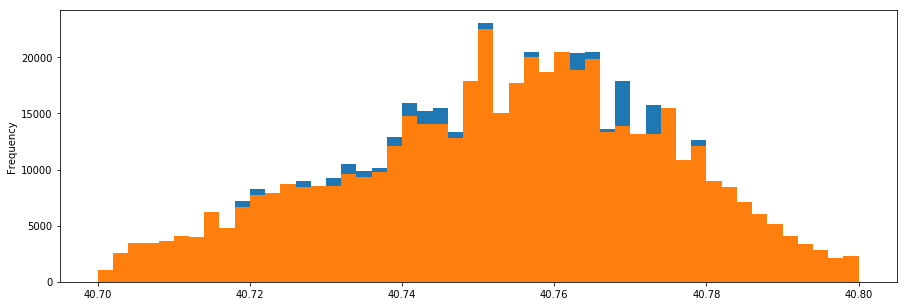

In [32]:
df_trips.pickup_latitude.plot(kind='hist', bins=50, figsize=(15, 5))
df_trips.dropoff_latitude.plot(kind='hist', bins=50, figsize=(15, 5))

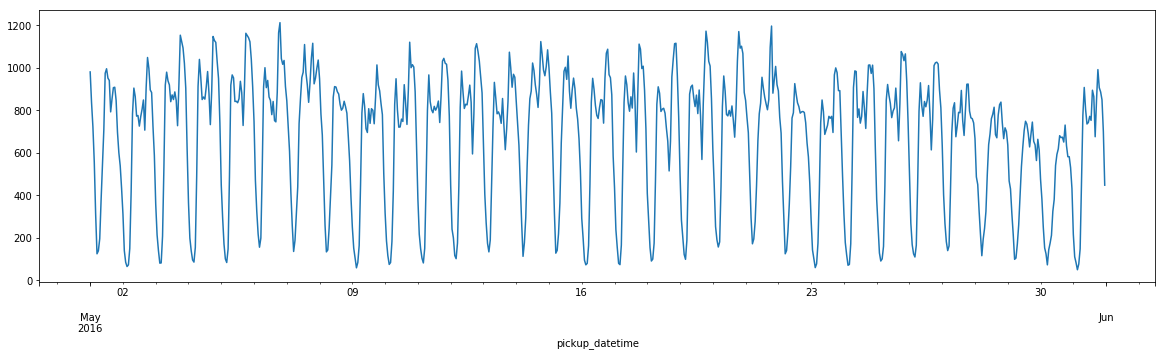

In [33]:
df_trips.resample('3600S', on='pickup_datetime').pickup_longitude.count().plot(figsize=(20, 5))

In [34]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)

In [35]:
cluster_labels = clusterer.fit_predict(df_trips[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values)

In [36]:
df_trips['cluster_label'] = cluster_labels

In [37]:
df_trips.cluster_label.value_counts()

 113    450497
-1       17740
 52      10703
 68       7275
 79       7096
 57       1226
 19        499
 90        352
 110       333
 32        227
 47        215
 66        202
 67        168
 72        151
 39        149
 109       136
 64        134
 62        131
 29        119
 93        119
 101       112
 13         85
 58         83
 55         83
 112        72
 83         69
 50         51
 73         50
 75         47
 56         46
         ...  
 7          16
 88         16
 69         15
 18         15
 102        15
 100        15
 0          15
 11         15
 80         14
 30         14
 41         14
 20         13
 17         13
 10         13
 6          13
 78         13
 49         12
 86         12
 111        11
 15         11
 22         11
 33         11
 91         11
 96         11
 26         10
 5          10
 84         10
 61         10
 2          10
 1          10
Name: cluster_label, Length: 116, dtype: int64

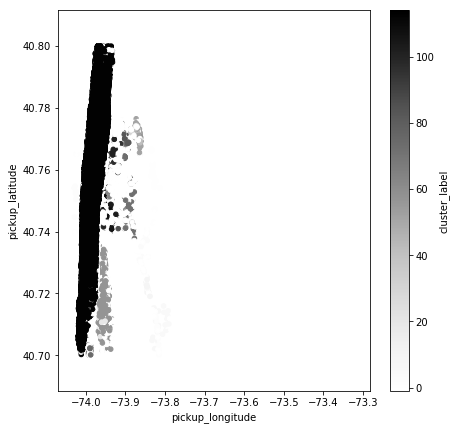

In [38]:
df_trips.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
              figsize=(7, 7), c='cluster_label', sharex=False)

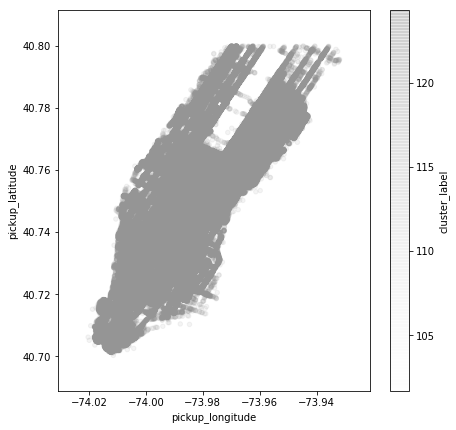

In [40]:
df_trips[df_trips.cluster_label==113].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
                                           figsize=(7, 7), c='cluster_label', sharex=False, alpha=0.1)

In [41]:
clusterer_mnh = hdbscan.HDBSCAN(min_cluster_size=10)

In [43]:
df_trips_mnh = df_trips[df_trips.cluster_label==113]

In [44]:
len(df_trips_mnh)

450497

In [45]:
df_trips_mnh['cluster_label'] = clusterer_mnh.fit_predict(df_trips[df_trips.cluster_label==113][[
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values)

In [46]:
df_trips_mnh.cluster_label.value_counts()

-1       371166
 2538       980
 2404       964
 1851       881
 2298       740
 2483       610
 2079       554
 2348       509
 822        449
 2369       423
 1455       417
 2451       400
 1929       352
 2127       293
 2522       287
 2297       278
 2037       274
 2515       263
 231        253
 28         252
 1147       249
 2217       246
 230        245
 356        237
 2280       237
 621        236
 2460       231
 1999       225
 2199       220
 2155       205
          ...  
 375         10
 1234        10
 1595        10
 2109        10
 1654        10
 1084        10
 61          10
 420         10
 2171        10
 477         10
 47          10
 299         10
 383         10
 1755        10
 672         10
 1754        10
 1581        10
 1582        10
 2523        10
 673         10
 634         10
 217         10
 1403        10
 216         10
 1239        10
 1914        10
 308         10
 1494        10
 1187        10
 0           10
Name: cluster_label, Len

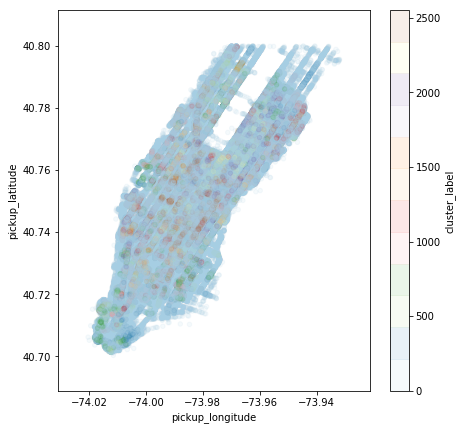

In [47]:
df_trips_mnh.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
                  figsize=(7, 7), c='cluster_label', cmap=plt.get_cmap('Paired'), sharex=False, alpha=0.1)

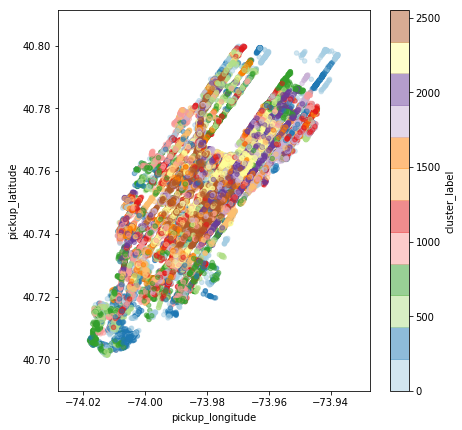

In [50]:
df_trips_mnh[df_trips_mnh.cluster_label!=-1].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
                  figsize=(7, 7), c='cluster_label', cmap=plt.get_cmap('Paired'), sharex=False, alpha=0.5)

In [51]:
clusterer_pickup = hdbscan.HDBSCAN(min_cluster_size=3)

In [52]:
df_trips_mnh['cluster_labels_pickup'] = clusterer_pickup.fit_predict(df_trips_mnh[['pickup_longitude', 'pickup_latitude']].values)

In [53]:
df_trips_mnh.cluster_labels_pickup.value_counts()

-1        169329
 6003        315
 16303       231
 12508       228
 25732       209
 3920        203
 7948        195
 3227        192
 14714       187
 1470        186
 1394        182
 9191        177
 977         168
 16583       167
 13314       159
 29350       156
 6212        154
 6385        154
 6300        152
 25081       152
 8436        151
 17808       150
 2446        148
 17173       147
 19614       146
 16760       145
 2255        144
 32266       144
 4756        143
 14200       141
           ...  
 4775          3
 12139         3
 27664         3
 31762         3
 19036         3
 17429         3
 21433         3
 21527         3
 11288         3
 16692         3
 25523         3
 9455          3
 9834          3
 20362         3
 21967         3
 12166         3
 14754         3
 32484         3
 285           3
 18147         3
 12707         3
 27048         3
 5609          3
 5297          3
 14651         3
 16917         3
 30349         3
 1646         

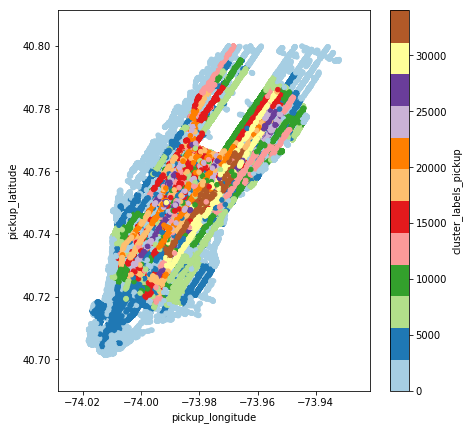

In [55]:
df_trips_mnh[df_trips_mnh.cluster_labels_pickup!=-1].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
                  figsize=(7, 7), c='cluster_labels_pickup', cmap=plt.get_cmap('Paired'), sharex=False)

### Applying t-SNE to 4-dimensional trip points

In [ ]:
# using MultiCore version of TSNE
trips_emb = pd.DataFrame(TSNE(n_components=2).fit_transform(df_trips[['pickup_longitude', 'pickup_latitude', 
                                                         'dropoff_longitude', 'dropoff_latitude']].sample(n=100000).values), 
                         columns=['dim1', 'dim2'])

In [48]:
trips_emb.head()

,dim1,dim2,cluster_label
0,15.283422,28.419616,4
1,-18.880345,13.138587,1055
2,11.346406,-9.882905,2654
3,22.939138,17.773450,-1
4,15.130579,16.394790,1341


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)

In [ ]:
trips_emb['cluster_label'] = clusterer.fit_predict(trips_emb[['dim1', 'dim2']].values)

In [ ]:
trips_emb.cluster_label.value_counts()

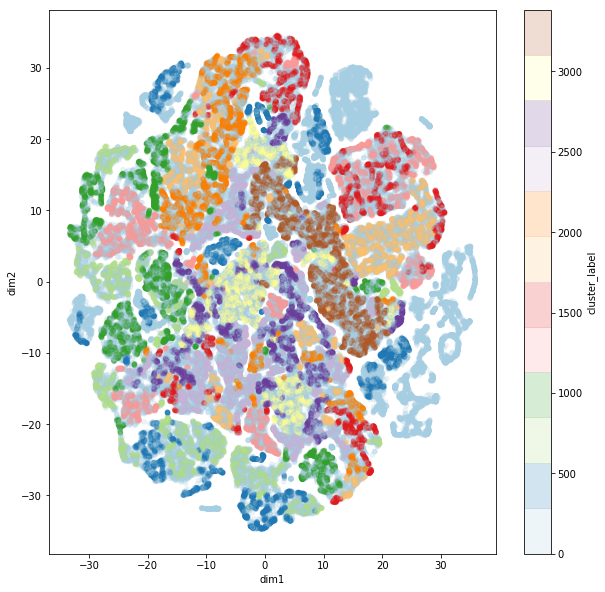

In [57]:
trips_emb.plot(kind='scatter', x='dim1', y='dim2', 
               figsize=(10, 10), alpha=0.2, s=20, c='cluster_label', cmap=plt.get_cmap('Paired'), sharex=False)

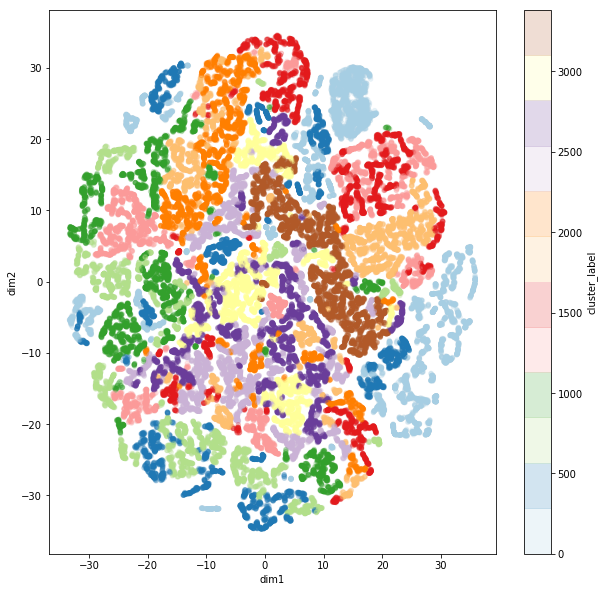

In [58]:
trips_emb[trips_emb.cluster_label!=-1].plot(kind='scatter', x='dim1', y='dim2', 
               figsize=(10, 10), alpha=0.2, s=20, c='cluster_label', cmap=plt.get_cmap('Paired'), sharex=False)